# Data Load

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import psycopg2
import time
from datetime import date, timedelta
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import boto3
from boto3.session import Session 
import pyarrow.parquet as pq

# Data Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Anomaly detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from kmodes.kmodes import KModes
from sklearn.decomposition import PCA

In [2]:
# Define DWH connection
with open ('/Users/patriciosanchez/Documents/Python/Connections/dwh.txt', 'r') as file:
    lines=file.readlines()
    dwh_host=lines[0].strip('\n')
    dwh_user=lines[1].strip('\n')
    dwh_port=lines[2].strip('\n')
    dwh_database=lines[3].strip('\n')
    dwh_password=lines[4].strip('\n')
    file.close()
    
con = psycopg2.connect(dbname= dwh_database,
                    host=dwh_host,
                    port= dwh_port,
                    user= dwh_user,
                    password= dwh_password)

In [3]:
# Define timeframe
delta = timedelta(days=1)
end_date = date(2021, 8, 25)
start_date = end_date-14*delta
courier = pd.DataFrame()

qry = '''
        select o.courier_id,
               c.transport,
               o.country_code,
               count(distinct(date_trunc('day', o.creation_time))) as active_days,
               count(distinct(o.id)) as orders,
               orders::float/active_days::float as order_per_day,
               count(distinct(o.customer_id)) as customers,
               customers::float/orders::float as customers_per_order,
               count(distinct(o.store_address_id)) as stores,
               stores::float/orders::float as stores_per_order,
               -- ORDERS
               coalesce(count(distinct(case when o.payment_status = 'PAID' then o.id end)), 0) as paid_orders,
               coalesce(count(distinct(case when o.payment_status = 'NOT_PAID' then o.id end)), 0) as unpaid_orders,
               coalesce(count(distinct(case when o.ordering_payment_method = 'CASH' then o.id end)), 0) as cash_orders,
               cash_orders::float/orders::float as cash_rate,
               coalesce(count(distinct(case when o.final_status = 'CanceledStatus' then o.id end)), 0) as cancel_orders,
               coalesce(count(distinct(case when o.final_status = 'DeliveredStatus' then o.id end)), 0) as delivered_orders,
               cancel_orders::float/(cancel_orders::float+delivered_orders::float+0.0001) as cancel_rate,
               coalesce(count(distinct(case when o.final_status = 'CanceledStatus' and o.ordering_payment_method = 'CASH' then o.id end)), 0) as cash_cancel_orders,
               coalesce(count(distinct(case when o.final_status = 'DeliveredStatus' and o.ordering_payment_method = 'CASH' then o.id end)), 0) as cash_delivered_orders,
               cash_cancel_orders::float/(cash_cancel_orders::float+cash_delivered_orders::float+0.0001) as cash_cancel_rate,
               coalesce(count(distinct(case when p.forgiven then o.id end)), 0) as forgiven_orders,
               forgiven_orders::float/(unpaid_orders::float+0.0001) as forgiven_rate,
               -- GTV METRICS
               sum(o.gtv/o.exchange_rate_currency) as gtv,
               avg(o.gtv/o.exchange_rate_currency) as gtv_avg,
               coalesce(sum(case when o.payment_status = 'PAID' and p.bundled_payment_parent_id is null then o.gtv/o.exchange_rate_currency end), 0) as paid_gtv,
               coalesce(sum(case when o.payment_status = 'NOT_PAID' and p.bundled_payment_parent_id is null then o.gtv/o.exchange_rate_currency end), 0) as unpaid_gtv,
               unpaid_gtv/(unpaid_gtv+paid_gtv+0.0001) as unpaid_rate,
               coalesce(sum(case when o.payment_status = 'PAID' and o.ordering_payment_method = 'CASH' and p.bundled_payment_parent_id is null then o.gtv/o.exchange_rate_currency end), 0) as cash_paid_gtv,
               coalesce(sum(case when o.payment_status = 'NOT_PAID' and o.ordering_payment_method = 'CASH' and p.bundled_payment_parent_id is null then o.gtv/o.exchange_rate_currency end), 0) as cash_unpaid_gtv,
               cash_unpaid_gtv/(cash_unpaid_gtv+cash_paid_gtv+0.0001) as cash_unpaid_rate,
               -- REASSIGNMENTS
               sum(crr.number_of_requests) as courier_reassignment_requests,
               avg(crr.number_of_requests) as courier_reassignment_requests_avg,
               -- DISTANCE / TIME / SPEED
               avg(case when o.final_status = 'DeliveredStatus' then o.courier_progress_time_minutes end) as avg_courier_progress_time_delivered,
               avg(case when o.final_status = 'DeliveredStatus' then o.distance_pickup_to_delivery end) as avg_distance_delivered,
               avg(case when o.final_status = 'DeliveredStatus' then o.total_delivery_time_minutes end) as avg_delivery_time_min,
               avg(case when o.final_status = 'DeliveredStatus' then o.distance_pickup_to_delivery/(total_delivery_time_minutes*60.0) end) as avg_speed_delivered,
               avg(case when o.final_status = 'CanceledStatus' then o.courier_progress_time_minutes end) as avg_courier_progress_time_canceled,
               avg(case when o.final_status = 'CanceledStatus' then o.distance_pickup_to_delivery end) as avg_distance_canceled,
               avg(case when o.final_status = 'CanceledStatus' then datediff(minutes, o.creation_time, o.cancellation_time) end) as avg_cancel_time_min,
               avg(case when o.final_status = 'CanceledStatus' and datediff(minutes, o.creation_time, o.cancellation_time)>5 then datediff(minutes, o.creation_time, o.cancellation_time) end) as avg_notimmediate_cancel_time_min,
               -- CUSTOMER TYPE
               coalesce(count(distinct(case when u.fraudulent is True then o.customer_id end)), 0) as fraudulent_customers,
               fraudulent_customers::float/customers::float as fraudulent_rate,
               coalesce(count(distinct(case when o.first_order is True then o.customer_id end)), 0) as nc_customers,
               nc_customers::float/customers::float as nc_rate,
               coalesce(count(distinct(case when o.is_prime is True then o.customer_id end)), 0) as prime_customers,
               prime_customers::float/customers::float as prime_rate,
               -- ORDER TYPE
               coalesce(count(distinct(case when u.fraudulent is True then o.id end)), 0) as fraudulent_orders,
               fraudulent_orders::float/orders::float as fraudulent_orders_rate,
               coalesce(count(distinct(case when o.first_order is True then o.id end)), 0) as nc_orders,
               nc_orders::float/orders::float as nc_orders_rate,
               coalesce(count(distinct(case when o.is_prime is True then o.id end)), 0) as prime_orders,
               prime_orders::float/orders::float as prime_orders_rate,
               coalesce(count(distinct(case when prom.type in ('DEFAULT', 'MGM') and prom.type is not null then o.id end)), 0) as promotion_orders,
               promotion_orders::float/orders::float as promotions_rate,
               coalesce(count(distinct(case when o.free_delivery is True then o.id end)), 0) as free_delivery_orders,
               free_delivery_orders::float/orders::float as free_delivery_rate,
               count(distinct(case when p.purpose like 'Compensation for%' and p.origin = 'GIFT' and o.free_delivery is False then o.id end)) as compensation_nofreeride_orders,
               compensation_nofreeride_orders::float/orders::float as compensations_nofreeride_rate,
               coalesce(count(distinct(case when datediff(minute, o.creation_time, o.delivery_time) < 5 then o.id end)), 0) as fast_orders,
               fast_orders::float/delivered_orders::float as fast_rate,
               coalesce(count(distinct(case when ori.id is not null and and ori.refunded is True then o.id end)), 0) as refund_orders,
               refund_orders::float/delivered_orders::float as refund_rate,
               -- COURIER EARNED
               coalesce(sum(o.courier_total_earned/o.exchange_rate_currency), 0) as courier_earned_gtv,
               coalesce(avg(o.courier_total_earned/o.exchange_rate_currency), 0) as avg_courier_earned_gtv,
               coalesce(avg(o.courier_total_earned/o.exchange_rate_currency - o.gtv/o.exchange_rate_currency), 0) as avg_courier_earned_minus_gtv,
               coalesce(avg(o.courier_total_earned/o.exchange_rate_currency - o.purchases_total_price/o.exchange_rate_currency), 0) as avg_courier_earned_minus_purchases_gtv,
               -- IMPACT LOSSES
               coalesce(sum(case when o.payment_status = 'NOT_PAID' then o.gtv/o.exchange_rate_currency end), 0) as gtv_unpaid,
               coalesce(sum(case when o.payment_status = 'NOT_PAID' then -amount_eur end), 0) as gtv_cbk,
               coalesce(sum(case when o.payment_status = 'NOT_PAID' and p.forgiven is True then o.gtv/o.exchange_rate_currency end), 0) as gtv_forgiven,
               coalesce(sum(case when prom.type in ('DEFAULT', 'MGM') and prom.type is not null then balance_eur end), 0) as gtv_promotions,
               coalesce(sum(case when prom.purpose like 'Compensation for%' and prom.origin = 'GIFT' and o.free_delivery is False then balance_eur end), 0) as gtv_compensation_nofreeride,
               coalesce(sum(case when prom.purpose like 'Compensation for%' and prom.origin = 'GIFT' and o.free_delivery is True then o.delivery_fee end), 0) as gtv_freeride,
               coalesce(sum(case when ori.id is not null and ori.refunded is True then ori.refunded_to_customer_eur end), 0) as gtv_refund
        from orders o
        join payments p on p.order_id = o.id
        join glovodwh.public.couriers c on c.id = o.courier_id
        join users u on o.customer_id = u.id
        left join courier_requested_reassignments crr on o.courier_id = crr.courier_id and crr.date = date_trunc('day', o.creation_time)
        left join order_pricings op on  o.id = op.order_id
        left join order_pricing_applied_discounts opad on opad.order_pricing_id = op.id
        left join promocode_uses pu on OPAD.promocode_use_id = pu.ID
        left join promocodes pcs ON PU.promocode_id=PCS.promocode_id
        left join promotions prom ON prom.id = pcs.promotion_id
        left join order_refund_incidents ori on ori.order_id = o.id
        left join fraud_po_chargeback_events fpce on o.id = fpce.order_id and fpce.type='transaction.chargeback.created'
        where 1=1
        and c.staff is False
        and o.creation_time >= \'''' + start_date.strftime("%Y-%m-%d") + '''\'
        and o.creation_time < \'''' + end_date.strftime("%Y-%m-%d") + '''\'
        group by 1, 2, 3
        having orders > 20
        ''' 

courier = pd.read_sql_query(qry, con)

# EDA - Univariate analysis

In [4]:
# Categorical encoding
courier = pd.merge(courier, pd.get_dummies(courier['transport']), how='inner', left_index=True, right_index=True)
le = LabelEncoder()
courier['country_label'] = le.fit_transform(courier.country_code.values)

# Data types
courier['cash_rate'] = courier['cash_rate'].astype('float')
courier['cancel_rate'] = courier['cancel_rate'].astype('float')
courier['avg_courier_progress_time_canceled'] = courier['avg_courier_progress_time_canceled'].astype('float')

# Data transformations
courier['avg_speed_delivered'] = courier['avg_speed_delivered']*3600
courier['customers_daily'] = courier['customers']/courier['active_days']
courier['stores_daily'] = courier['stores']/courier['active_days']
courier['courier_earned_gtv_daily'] = courier['courier_earned_gtv']/courier['active_days']
courier['courier_earned_gtv_per_delivered'] = courier['courier_earned_gtv']/courier['delivered_orders']
courier['courier_reassignment_requests_per_order'] = 1.0*courier['courier_reassignment_requests']/courier['orders']

# Create a "clean" DF without the total counts, only rates
courier_clean = courier.copy()
courier_clean.drop(['customers', 'stores', 'paid_orders', 'unpaid_orders', 'cash_orders', 'cancel_orders', 'cash_delivered_orders', 'cash_cancel_orders', 'forgiven_orders', 'gtv', 'paid_gtv', 'unpaid_gtv', 'cash_paid_gtv', 'cash_unpaid_gtv', 'courier_reassignment_requests', 'fraudulent_customers', 'nc_customers', 'prime_customers', 'fraudulent_orders', 'nc_orders', 'prime_orders', 'promotion_orders', 'fast_orders', 'courier_earned_gtv'], axis=1, inplace=True)

In [5]:
courier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38495 entries, 0 to 38494
Data columns (total 72 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   courier_id                               38495 non-null  int64  
 1   transport                                38495 non-null  object 
 2   country_code                             38495 non-null  object 
 3   active_days                              38495 non-null  int64  
 4   orders                                   38495 non-null  int64  
 5   order_per_day                            38495 non-null  float64
 6   customers                                38495 non-null  int64  
 7   customers_per_order                      38495 non-null  float64
 8   stores                                   38495 non-null  int64  
 9   stores_per_order                         38495 non-null  float64
 10  paid_orders                              38495

## Distplots

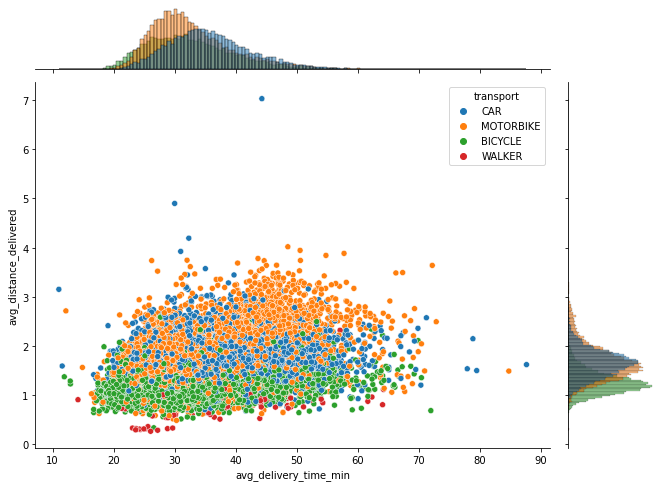

In [6]:
g = sns.JointGrid(data=courier, x="avg_delivery_time_min", y="avg_distance_delivered", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

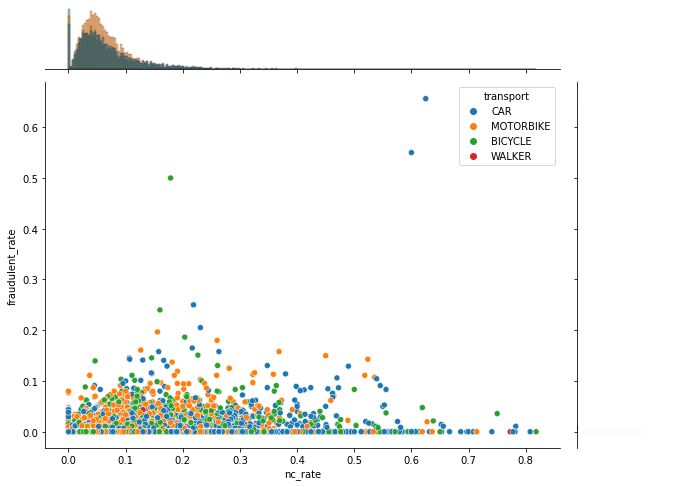

In [7]:
g = sns.JointGrid(data=courier, x="nc_rate", y="fraudulent_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

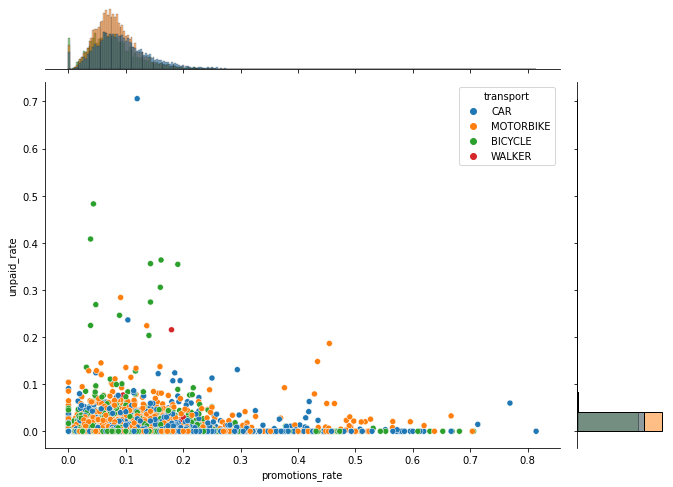

In [8]:
g = sns.JointGrid(data=courier, x="promotions_rate", y="unpaid_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

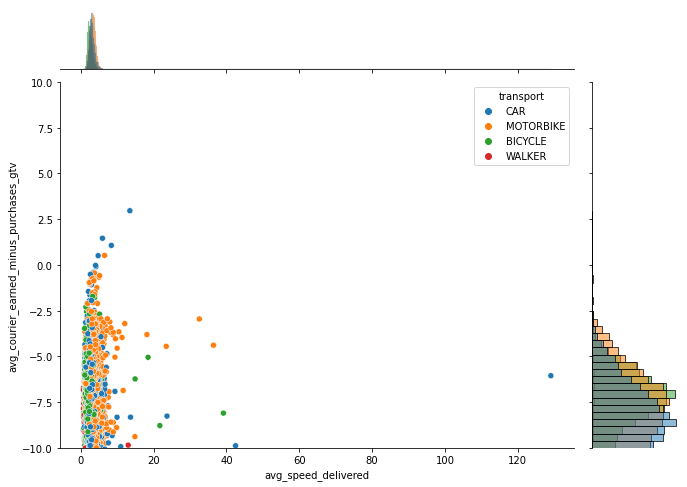

In [9]:
g = sns.JointGrid(data=courier, x="avg_speed_delivered", y="avg_courier_earned_minus_purchases_gtv", hue="transport")
g.fig.set_size_inches(10,7)
plt.ylim(-10,10)
g.plot(sns.scatterplot, sns.histplot)

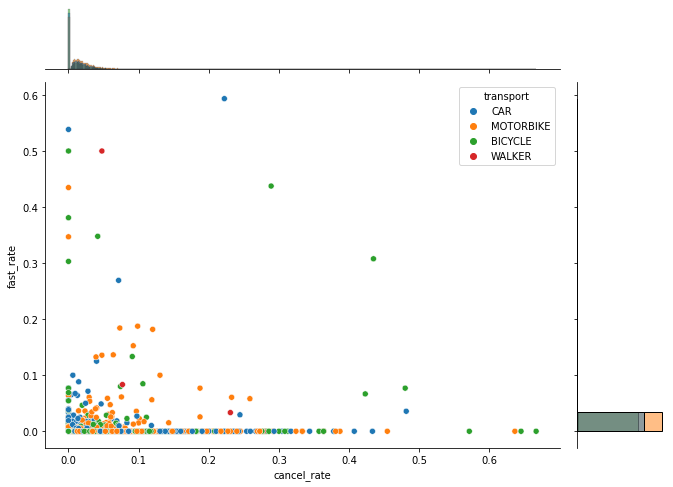

In [10]:
g = sns.JointGrid(data=courier, x="cancel_rate", y="fast_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

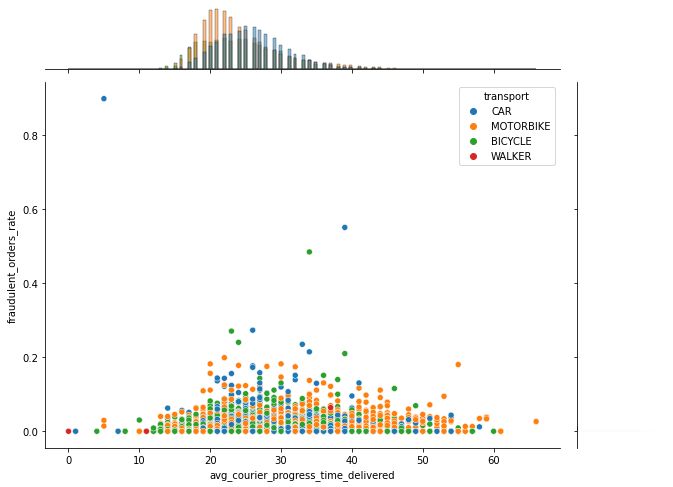

In [11]:
g = sns.JointGrid(data=courier, x="avg_courier_progress_time_delivered", y="fraudulent_orders_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

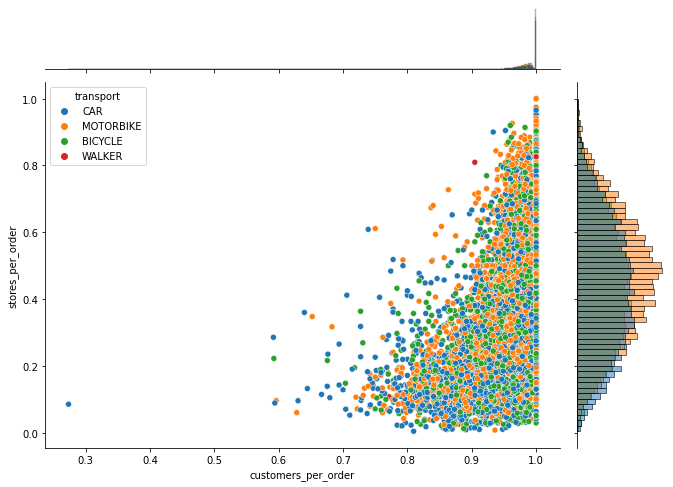

In [12]:
g = sns.JointGrid(data=courier, x="customers_per_order", y="stores_per_order", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

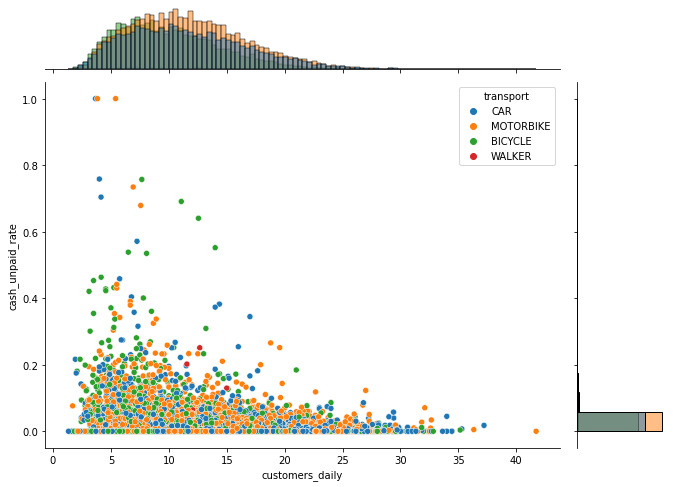

In [13]:
g = sns.JointGrid(data=courier, x="customers_daily", y="cash_unpaid_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

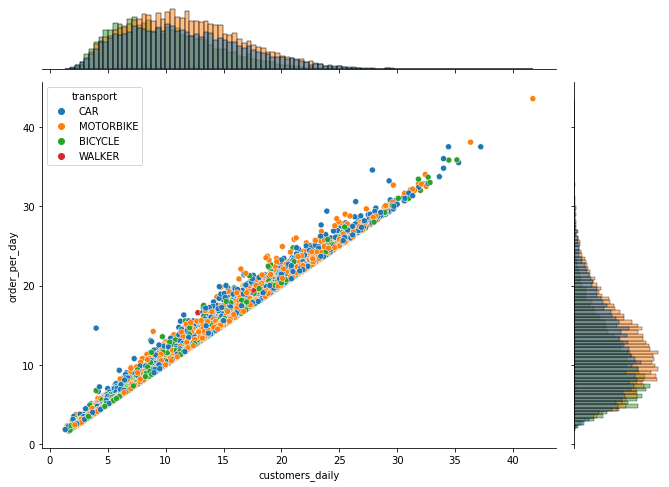

In [14]:
g = sns.JointGrid(data=courier, x="customers_daily", y="order_per_day", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

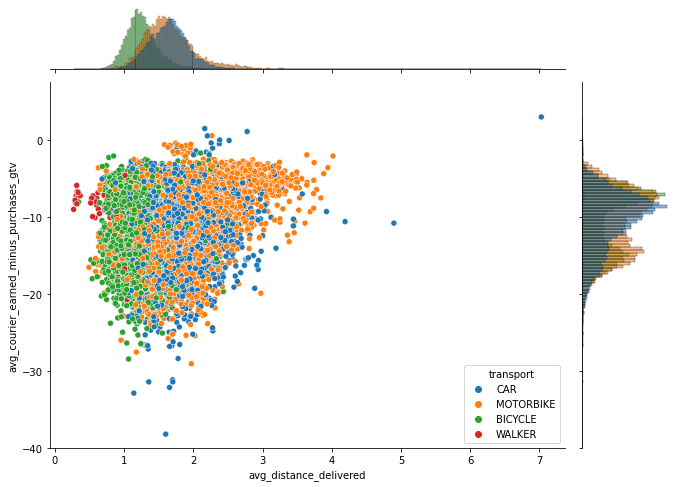

In [15]:
g = sns.JointGrid(data=courier, x="avg_distance_delivered", y="avg_courier_earned_minus_purchases_gtv", hue="transport")
g.fig.set_size_inches(10,7)
plt.ylim(-40,7.5)
g.plot(sns.scatterplot, sns.histplot)

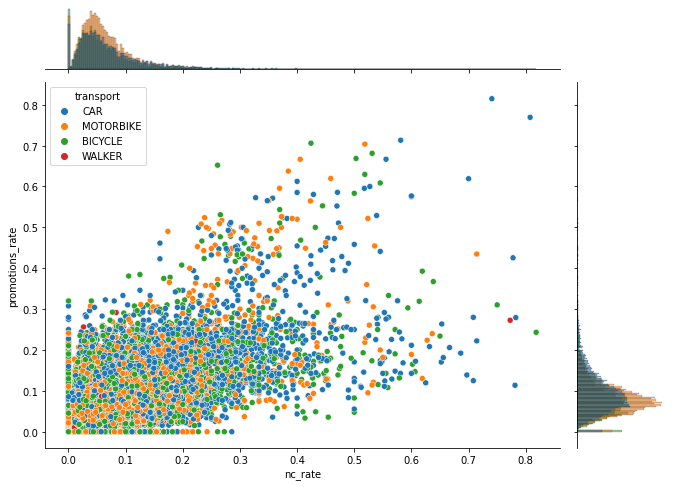

In [16]:
g = sns.JointGrid(data=courier, x="nc_rate", y="promotions_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

## Country differences

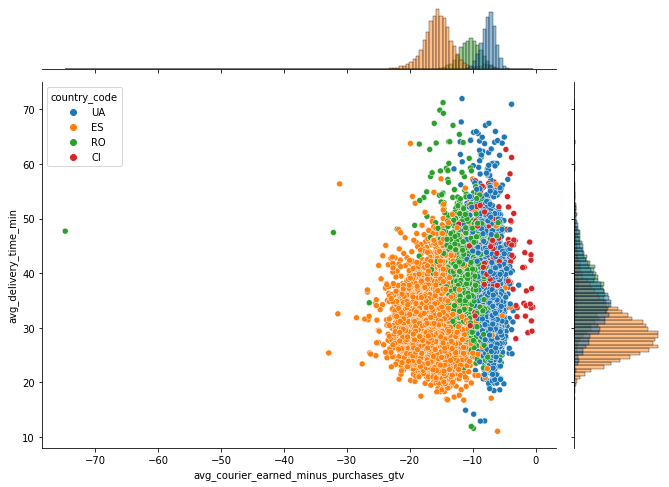

In [17]:
g = sns.JointGrid(data=courier[courier.country_code.isin(['ES', 'RO', 'CI', 'UA'])], x="avg_courier_earned_minus_purchases_gtv", y="avg_delivery_time_min", hue="country_code")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

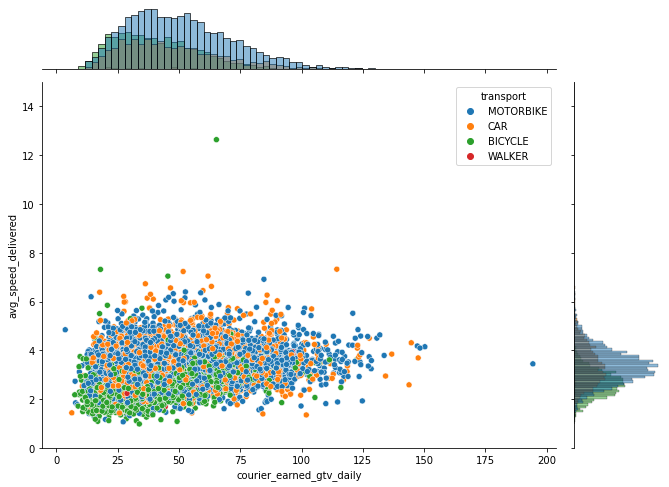

In [18]:
g = sns.JointGrid(data=courier[courier['country_code']=='ES'], x="courier_earned_gtv_daily", y="avg_speed_delivered", hue="transport")
g.fig.set_size_inches(10,7)
plt.ylim(0,15)
g.plot(sns.scatterplot, sns.histplot)

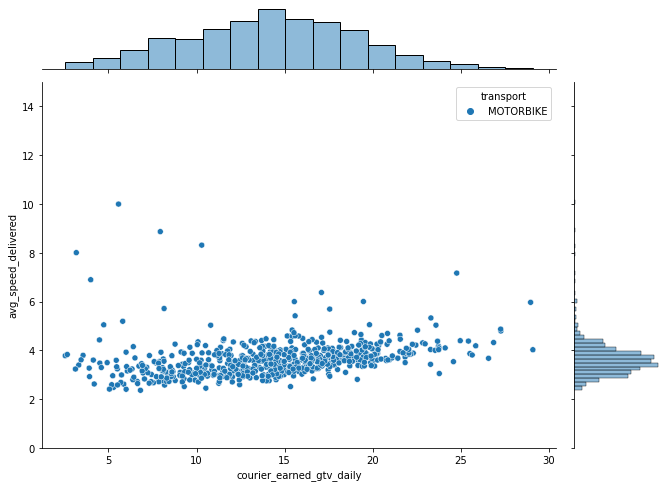

In [19]:
g = sns.JointGrid(data=courier[courier['country_code']=='CI'], x="courier_earned_gtv_daily", y="avg_speed_delivered", hue="transport")
g.fig.set_size_inches(10,7)
plt.ylim(0,15)
g.plot(sns.scatterplot, sns.histplot)

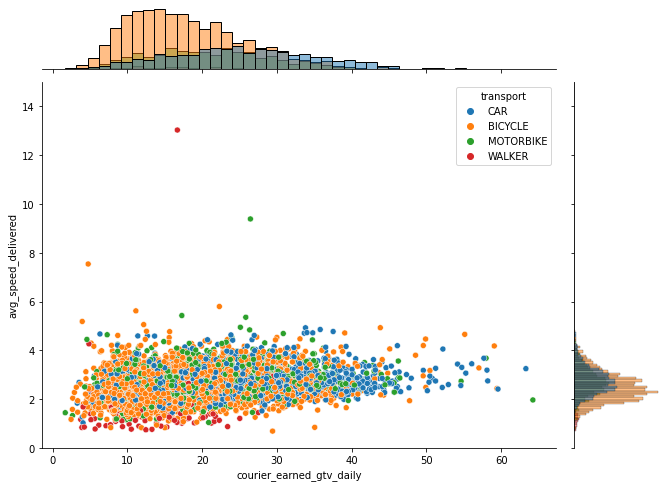

In [20]:
g = sns.JointGrid(data=courier[courier['country_code']=='UA'], x="courier_earned_gtv_daily", y="avg_speed_delivered", hue="transport")
g.fig.set_size_inches(10,7)
plt.ylim(0,15)
g.plot(sns.scatterplot, sns.histplot)

## Worst offenders

In [21]:
courier[courier['avg_delivery_time_min']<15]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
9877,62890758,MOTORBIKE,GH,3,49,16.333333,41,0.836735,33,0.673469,...,0,0,1,0,5,13.666667,11.000000,21.167328,1.295959,1.142857
23712,36497587,MOTORBIKE,UA,1,23,23.000000,23,1.000000,16,0.695652,...,0,0,1,0,20,23.000000,16.000000,36.936098,1.605917,3.000000
32712,58654678,WALKER,UA,1,21,21.000000,19,0.904762,17,0.809524,...,0,0,0,1,20,19.000000,17.000000,16.681140,0.834057,3.285714
32822,29630367,BICYCLE,UA,3,22,7.333333,22,1.000000,13,0.590909,...,1,0,0,0,20,7.333333,4.333333,9.677677,1.319683,3.136364
35612,58652669,BICYCLE,UA,3,21,7.000000,21,1.000000,16,0.761905,...,1,0,0,0,20,7.000000,5.333333,9.794660,1.399237,3.000000
36572,50981783,CAR,RO,6,26,4.333333,25,0.961538,16,0.615385,...,0,1,0,0,17,4.166667,2.666667,12.326474,2.844571,5.769231
38261,66326107,BICYCLE,RO,3,45,15.000000,42,0.933333,11,0.244444,...,1,0,0,0,17,14.000000,3.666667,30.779157,2.885546,5.222222


In [22]:
courier[courier['avg_speed_delivered']>15]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
2984,60409671,MOTORBIKE,CI,13,147,11.307692,109,0.741497,26,0.176871,...,0,0,1,0,2,8.384615,2.000000,12.513367,1.161956,0.285714
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
9877,62890758,MOTORBIKE,GH,3,49,16.333333,41,0.836735,33,0.673469,...,0,0,1,0,5,13.666667,11.000000,21.167328,1.295959,1.142857
23310,57396077,MOTORBIKE,CI,7,65,9.285714,62,0.953846,25,0.384615,...,0,0,1,0,2,8.857143,3.571429,21.619448,2.565019,1.138462
23712,36497587,MOTORBIKE,UA,1,23,23.000000,23,1.000000,16,0.695652,...,0,0,1,0,20,23.000000,16.000000,36.936098,1.605917,3.000000
27164,66327245,BICYCLE,RO,3,23,7.666667,23,1.000000,11,0.478261,...,1,0,0,0,17,7.666667,3.666667,14.835645,3.423610,4.130435
30226,33816932,CAR,PL,3,28,9.333333,28,1.000000,20,0.714286,...,0,1,0,0,15,9.333333,6.666667,12.138472,1.400593,1.785714
32822,29630367,BICYCLE,UA,3,22,7.333333,22,1.000000,13,0.590909,...,1,0,0,0,20,7.333333,4.333333,9.677677,1.319683,3.136364
32885,42960935,BICYCLE,UA,3,33,11.000000,32,0.969697,16,0.484848,...,1,0,0,0,20,10.666667,5.333333,17.259916,1.569083,3.090909
35457,61105040,MOTORBIKE,CI,13,101,7.769231,97,0.960396,31,0.306931,...,0,0,1,0,2,7.461538,2.384615,13.427006,1.961248,0.435644


In [71]:
courier[courier['customers_per_order']<0.7]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
201,57449785,BICYCLE,IT,13,37,2.846154,25,0.675676,8,0.216216,...,1,0,0,0,7,1.923077,0.615385,12.295385,5.708571,NaN
1464,61405959,CAR,IT,11,73,6.636364,46,0.630137,7,0.095890,...,0,1,0,0,7,4.181818,0.636364,55.196364,8.799420,0.410959
1686,63854576,CAR,IT,13,121,9.307692,78,0.644628,16,0.132231,...,0,1,0,0,7,6.000000,1.230769,61.277692,7.308349,NaN
4628,53785137,CAR,UA,14,151,10.785714,102,0.675497,21,0.139073,...,0,1,0,0,20,7.285714,1.500000,20.836141,1.970986,0.649007
7139,58210201,CAR,ES,14,183,13.071429,122,0.666667,21,0.114754,...,0,1,0,0,3,8.714286,1.500000,82.870000,6.409834,NaN
7969,58051573,MOTORBIKE,IT,14,41,2.928571,28,0.682927,13,0.317073,...,0,0,1,0,7,2.000000,0.928571,20.711429,8.054444,NaN
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
15167,65000297,CAR,PL,9,34,3.777778,23,0.676471,8,0.235294,...,0,1,0,0,15,2.555556,0.888889,7.849473,2.140765,NaN
19770,65517519,MOTORBIKE,MA,14,52,3.714286,31,0.596154,5,0.096154,...,0,0,1,0,11,2.214286,0.357143,4.928794,1.380062,NaN
20346,65381514,CAR,IT,14,49,3.500000,29,0.591837,14,0.285714,...,0,1,0,0,7,2.071429,1.000000,20.347143,6.947805,NaN


In [24]:
courier[courier['cancel_rate']>0.3]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
1308,56121792,CAR,IT,7,21,3.000000,21,1.000000,8,0.380952,...,0,1,0,0,7,3.000000,1.142857,17.384286,8.692143,3.047619
3187,62285513,CAR,IT,13,60,4.615385,54,0.900000,13,0.216667,...,0,1,0,0,7,4.153846,1.000000,17.133077,6.550882,14.066667
3470,66366877,BICYCLE,RO,4,21,5.250000,21,1.000000,11,0.523810,...,1,0,0,0,17,5.250000,2.750000,9.917222,5.666984,5.000000
5328,65444045,MOTORBIKE,NG,5,21,4.200000,19,0.904762,15,0.714286,...,0,0,1,0,14,3.800000,3.000000,6.513568,2.326274,NaN
5662,42828108,CAR,IT,8,22,2.750000,22,1.000000,11,0.500000,...,0,1,0,0,7,2.750000,1.375000,11.690000,6.680000,12.272727
11705,22623712,MOTORBIKE,ES,13,21,1.615385,21,1.000000,16,0.761905,...,0,0,1,0,3,1.615385,1.230769,3.595385,3.338571,11.952381
12563,58551067,BICYCLE,IT,10,22,2.200000,18,0.818182,10,0.454545,...,1,0,0,0,7,1.800000,1.000000,12.154000,8.681429,NaN
13962,66930816,BICYCLE,RO,4,26,6.500000,26,1.000000,15,0.576923,...,1,0,0,0,17,6.500000,3.750000,15.343170,4.091512,5.153846
14375,32551338,BICYCLE,ES,10,32,3.200000,32,1.000000,11,0.343750,...,1,0,0,0,3,3.200000,1.100000,10.230000,4.650000,3.781250
15273,65518703,MOTORBIKE,CI,10,33,3.300000,27,0.818182,13,0.393939,...,0,0,1,0,2,2.700000,1.300000,2.661302,1.267287,NaN


In [25]:
courier[(courier['cash_unpaid_rate']>0.7)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
5182,56364373,CAR,IT,6,22,3.666667,22,1.000000,5,0.227273,...,0,1,0,0,7,3.666667,0.833333,25.233333,8.411111,3.227273
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
17099,2316826,MOTORBIKE,ES,5,27,5.400000,27,1.000000,16,0.592593,...,0,0,1,0,3,5.400000,3.200000,24.854000,4.970800,0.740741
17460,51678761,MOTORBIKE,ES,12,85,7.083333,83,0.976471,23,0.270588,...,0,0,1,0,3,6.916667,1.916667,29.651667,4.874247,4.694118
26214,6511805,MOTORBIKE,ES,6,24,4.000000,23,0.958333,16,0.666667,...,0,0,1,0,3,3.833333,2.666667,12.405000,3.236087,1.708333
27164,66327245,BICYCLE,RO,3,23,7.666667,23,1.000000,11,0.478261,...,1,0,0,0,17,7.666667,3.666667,14.835645,3.423610,4.130435
36196,58537714,CAR,PL,7,29,4.142857,29,1.000000,23,0.793103,...,0,1,0,0,15,4.142857,3.285714,14.979463,4.194250,3.137931


In [26]:
courier[(courier['forgiven_rate']>0.3) & (courier['unpaid_orders']>5)][['courier_id', 'active_days', 'orders', 'unpaid_orders', 'forgiven_orders', 'forgiven_rate']]

,courier_id,active_days,orders,unpaid_orders,forgiven_orders,forgiven_rate
650,50656620,14,285,8,4,0.499994
1760,48427484,13,250,6,3,0.499992
3439,39988542,13,127,7,5,0.714276
3470,66366877,4,21,8,4,0.499994
5549,27528124,12,165,6,2,0.333328
6164,55115770,6,54,7,3,0.428565
8029,54175961,10,53,7,4,0.571420
9393,28796914,13,177,6,3,0.499992
11553,26406154,14,172,7,4,0.571420
11878,52313193,8,121,6,4,0.666656


In [27]:
courier[(courier['forgiven_rate']>0.3) & (courier['unpaid_orders']>5)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
650,50656620,MOTORBIKE,PT,14,285,20.357143,277,0.971930,126,0.442105,...,0,0,1,0,16,19.785714,9.000000,81.908571,4.247111,0.656140
1760,48427484,MOTORBIKE,IT,13,250,19.230769,243,0.972000,33,0.132000,...,0,0,1,0,7,18.692308,2.538462,67.600769,3.739617,13.664000
3439,39988542,MOTORBIKE,IT,13,127,9.769231,124,0.976378,36,0.283465,...,0,0,1,0,7,9.538462,2.769231,38.589231,4.251356,1.181102
3470,66366877,BICYCLE,RO,4,21,5.250000,21,1.000000,11,0.523810,...,1,0,0,0,17,5.250000,2.750000,9.917222,5.666984,5.000000
5549,27528124,MOTORBIKE,CI,12,165,13.750000,164,0.993939,69,0.418182,...,0,0,1,0,2,13.666667,5.750000,18.185770,1.398905,0.854545
6164,55115770,MOTORBIKE,PT,6,54,9.000000,52,0.962963,27,0.500000,...,0,0,1,0,16,8.666667,4.500000,31.933333,4.257778,0.259259
8029,54175961,MOTORBIKE,ES,10,53,5.300000,53,1.000000,29,0.547170,...,0,0,1,0,3,5.300000,2.900000,15.324000,3.831000,29.396226
9393,28796914,MOTORBIKE,IT,13,177,13.615385,172,0.971751,43,0.242938,...,0,0,1,0,7,13.230769,3.307692,47.143077,3.605059,5.152542
11553,26406154,MOTORBIKE,CI,14,172,12.285714,168,0.976744,59,0.343023,...,0,0,1,0,2,12.000000,4.214286,20.211255,1.802278,0.441860
11878,52313193,CAR,RO,8,121,15.125000,121,1.000000,72,0.595041,...,0,1,0,0,17,15.125000,9.000000,43.603536,3.260077,0.909091


In [28]:
courier[(courier['fast_rate']>0.2)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
377,55154724,BICYCLE,PL,5,24,4.800000,24,1.000000,17,0.708333,...,1,0,0,0,15,4.800000,3.400000,7.528477,1.636626,1.250000
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
9877,62890758,MOTORBIKE,GH,3,49,16.333333,41,0.836735,33,0.673469,...,0,0,1,0,5,13.666667,11.000000,21.167328,1.295959,1.142857
23712,36497587,MOTORBIKE,UA,1,23,23.000000,23,1.000000,16,0.695652,...,0,0,1,0,20,23.000000,16.000000,36.936098,1.605917,3.000000
27164,66327245,BICYCLE,RO,3,23,7.666667,23,1.000000,11,0.478261,...,1,0,0,0,17,7.666667,3.666667,14.835645,3.423610,4.130435
30226,33816932,CAR,PL,3,28,9.333333,28,1.000000,20,0.714286,...,0,1,0,0,15,9.333333,6.666667,12.138472,1.400593,1.785714
32712,58654678,WALKER,UA,1,21,21.000000,19,0.904762,17,0.809524,...,0,0,0,1,20,19.000000,17.000000,16.681140,0.834057,3.285714
32822,29630367,BICYCLE,UA,3,22,7.333333,22,1.000000,13,0.590909,...,1,0,0,0,20,7.333333,4.333333,9.677677,1.319683,3.136364
32885,42960935,BICYCLE,UA,3,33,11.000000,32,0.969697,16,0.484848,...,1,0,0,0,20,10.666667,5.333333,17.259916,1.569083,3.090909
35612,58652669,BICYCLE,UA,3,21,7.000000,21,1.000000,16,0.761905,...,1,0,0,0,20,7.000000,5.333333,9.794660,1.399237,3.000000


In [29]:
courier[(courier['fraudulent_rate']>0.15)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
3679,46715145,CAR,PL,3,33,11.000000,32,0.969697,7,0.212121,...,0,1,0,0,15,10.666667,2.333333,47.270607,4.431619,2.363636
3828,67278942,MOTORBIKE,CI,6,40,6.666667,38,0.950000,11,0.275000,...,0,0,1,0,2,6.333333,1.833333,5.999885,1.058803,0.275000
5688,52081250,CAR,PL,12,40,3.333333,40,1.000000,13,0.325000,...,0,1,0,0,15,3.333333,1.083333,25.181990,7.554597,3.475000
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
12131,46081864,MOTORBIKE,PL,13,50,3.846154,50,1.000000,32,0.640000,...,0,0,1,0,15,3.846154,2.461538,21.070146,5.827913,3.680000
13594,58584048,MOTORBIKE,PL,10,131,13.100000,122,0.931298,14,0.106870,...,0,0,1,0,15,12.200000,1.400000,45.281347,3.651722,2.633588
15045,57344533,CAR,PL,5,42,8.400000,39,0.928571,10,0.238095,...,0,1,0,0,15,7.800000,2.000000,38.926603,4.865825,1.380952
15343,66323487,BICYCLE,UA,9,31,3.444444,28,0.903226,12,0.387097,...,1,0,0,0,20,3.111111,1.333333,2.645650,2.164623,2.387097
16162,62395201,CAR,SI,6,38,6.333333,38,1.000000,19,0.500000,...,0,1,0,0,19,6.333333,3.166667,48.148333,7.602368,0.394737
17300,48116114,BICYCLE,PL,6,62,10.333333,59,0.951613,11,0.177419,...,1,0,0,0,15,9.833333,1.833333,44.952674,4.421575,1.387097


In [30]:
courier[(courier['avg_courier_earned_minus_purchases_gtv']>-1)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
2516,47592938,CAR,KZ,10,78,7.800000,76,0.974359,39,0.500000,...,0,1,0,0,10,7.600000,3.900000,61.226953,8.056178,0.397436
5688,52081250,CAR,PL,12,40,3.333333,40,1.000000,13,0.325000,...,0,1,0,0,15,3.333333,1.083333,25.181990,7.554597,3.475000
9828,61658641,CAR,KZ,9,76,8.444444,72,0.947368,36,0.473684,...,0,1,0,0,10,8.000000,4.000000,54.465388,6.535847,0.828947
12138,59109798,MOTORBIKE,CI,13,93,7.153846,76,0.817204,19,0.204301,...,0,0,1,0,2,5.846154,1.461538,7.439043,1.239840,0.236559
12515,65052617,MOTORBIKE,CI,8,24,3.000000,22,0.916667,12,0.500000,...,0,0,1,0,2,2.750000,1.500000,2.545708,1.197980,NaN
12964,29532166,CAR,KZ,12,85,7.083333,68,0.800000,35,0.411765,...,0,1,0,0,10,5.666667,2.916667,55.978996,7.902917,0.647059
13535,59053199,MOTORBIKE,CI,13,63,4.846154,51,0.809524,15,0.238095,...,0,0,1,0,2,3.923077,1.153846,5.243074,1.363199,0.492063
15140,65055411,MOTORBIKE,CI,13,60,4.615385,54,0.900000,14,0.233333,...,0,0,1,0,2,4.153846,1.076923,4.140046,1.015483,NaN
19578,53383532,CAR,KZ,11,80,7.272727,78,0.975000,38,0.475000,...,0,1,0,0,10,7.090909,3.454545,56.869454,8.020051,1.400000
20983,30366105,CAR,KZ,13,84,6.461538,79,0.940476,35,0.416667,...,0,1,0,0,10,6.076923,2.692308,43.136567,6.838724,0.607143


In [31]:
courier[(courier['free_delivery_rate']>0.7)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
127,61551834,CAR,PL,4,36,9.000000,33,0.916667,1,0.027778,...,0,1,0,0,15,8.250000,0.250000,15.915376,1.768375,NaN
1686,63854576,CAR,IT,13,121,9.307692,78,0.644628,16,0.132231,...,0,1,0,0,7,6.000000,1.230769,61.277692,7.308349,NaN
2036,66936741,BICYCLE,IT,6,21,3.500000,20,0.952381,9,0.428571,...,1,0,0,0,7,3.333333,1.500000,14.711667,5.192353,NaN
6013,59216331,CAR,PL,12,96,8.000000,91,0.947917,1,0.010417,...,0,1,0,0,15,7.583333,0.083333,17.523254,2.213464,0.093750
7071,18533093,BICYCLE,IT,11,49,4.454545,47,0.959184,8,0.163265,...,1,0,0,0,7,4.272727,0.727273,28.978182,7.244545,0.489796
8183,61523339,CAR,PL,11,95,8.636364,82,0.863158,1,0.010526,...,0,1,0,0,15,7.454545,0.090909,16.478884,1.949115,0.378947
8839,61700988,MOTORBIKE,IT,5,23,4.600000,21,0.913043,10,0.434783,...,0,0,1,0,7,4.200000,2.000000,24.354000,6.088500,NaN
12619,61551568,BICYCLE,PL,6,36,6.000000,35,0.972222,1,0.027778,...,1,0,0,0,15,5.833333,0.166667,15.369898,2.561650,0.361111
13078,66731023,MOTORBIKE,NG,8,38,4.750000,35,0.921053,15,0.394737,...,0,0,1,0,14,4.375000,1.875000,6.787625,1.597088,NaN
15725,64794626,MOTORBIKE,NG,9,32,3.555556,27,0.843750,13,0.406250,...,0,0,1,0,14,3.000000,1.444444,5.544551,1.848184,0.375000


In [70]:
courier[(courier['stores_per_order']<0.03)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
127,61551834,CAR,PL,4,36,9.000000,33,0.916667,1,0.027778,...,0,1,0,0,15,8.250000,0.250000,15.915376,1.768375,NaN
1979,61404074,CAR,PL,13,134,10.307692,119,0.888060,3,0.022388,...,0,1,0,0,15,9.153846,0.230769,17.323903,1.693314,0.507463
3403,57882396,BICYCLE,PL,12,117,9.750000,103,0.880342,3,0.025641,...,1,0,0,0,15,8.583333,0.250000,25.843601,2.650626,0.683761
6013,59216331,CAR,PL,12,96,8.000000,91,0.947917,1,0.010417,...,0,1,0,0,15,7.583333,0.083333,17.523254,2.213464,0.093750
7147,65000429,BICYCLE,PL,14,109,7.785714,95,0.871560,3,0.027523,...,1,0,0,0,15,6.785714,0.214286,12.269972,1.575960,NaN
7754,61389230,CAR,PL,12,111,9.250000,92,0.828829,2,0.018018,...,0,1,0,0,15,7.666667,0.166667,14.426995,1.573854,0.342342
8183,61523339,CAR,PL,11,95,8.636364,82,0.863158,1,0.010526,...,0,1,0,0,15,7.454545,0.090909,16.478884,1.949115,0.378947
8886,59494687,CAR,PL,13,186,14.307692,159,0.854839,3,0.016129,...,0,1,0,0,15,12.230769,0.230769,22.851224,1.632230,0.951613
10633,59000344,CAR,PL,12,69,5.750000,62,0.898551,1,0.014493,...,0,1,0,0,15,5.166667,0.083333,11.326468,1.969820,NaN
10869,63219977,CAR,PL,8,77,9.625000,71,0.922078,2,0.025974,...,0,1,0,0,15,8.875000,0.250000,32.206762,3.346157,2.012987


In [33]:
courier[(courier['courier_reassignment_requests_per_order']>35)]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
460,2832116,MOTORBIKE,IT,14,233,16.642857,225,0.965665,100,0.429185,...,0,0,1,0,7,16.071429,7.142857,115.133571,7.100749,38.257511
1539,17403457,BICYCLE,IT,12,218,18.166667,210,0.963303,71,0.325688,...,1,0,0,0,7,17.500000,5.916667,53.905000,2.994722,39.587156
2436,16018662,MOTORBIKE,ES,13,209,16.076923,193,0.923445,56,0.267943,...,0,0,1,0,3,14.846154,4.307692,98.213846,6.289557,35.688995
2987,57974332,MOTORBIKE,IT,6,80,13.333333,79,0.987500,45,0.562500,...,0,0,1,0,7,13.166667,7.500000,79.935000,6.071013,39.375000
6064,4346823,MOTORBIKE,IT,14,305,21.785714,296,0.970492,129,0.422951,...,0,0,1,0,7,21.142857,9.214286,131.473571,6.260646,39.649180
10399,52638488,BICYCLE,IT,13,90,6.923077,79,0.877778,22,0.244444,...,1,0,0,0,7,6.076923,1.692308,43.393846,7.051500,42.977778
15321,56739037,MOTORBIKE,IT,5,46,9.200000,46,1.000000,28,0.608696,...,0,0,1,0,7,9.200000,5.600000,67.184000,7.464889,44.217391
24787,21148802,CAR,IT,8,63,7.875000,63,1.000000,20,0.317460,...,0,1,0,0,7,7.875000,2.500000,37.341250,6.494130,35.873016
28309,66668059,MOTORBIKE,IT,2,36,18.000000,35,0.972222,12,0.333333,...,0,0,1,0,7,17.500000,6.000000,66.200000,3.894118,44.333333
29001,43304291,CAR,IT,8,27,3.375000,27,1.000000,9,0.333333,...,0,1,0,0,7,3.375000,1.125000,12.226250,6.113125,45.592593


In [34]:
courier[(courier['courier_earned_gtv_per_delivered']>12)] 

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
2374,52391510,CAR,ES,9,55,6.111111,54,0.981818,31,0.563636,...,0,1,0,0,3,6.000000,3.444444,74.944444,12.263636,10.000000
2576,22572118,CAR,ES,6,37,6.166667,37,1.000000,21,0.567568,...,0,1,0,0,3,6.166667,3.500000,83.245000,13.874167,3.486486
9643,57474372,CAR,IT,12,39,3.250000,30,0.769231,6,0.153846,...,0,1,0,0,7,2.500000,0.500000,39.684167,12.210513,NaN
9920,30669428,MOTORBIKE,ES,11,89,8.090909,89,1.000000,48,0.539326,...,0,0,1,0,3,8.090909,4.363636,111.257273,13.907159,4.820225
10004,56497384,CAR,ES,4,30,7.500000,29,0.966667,9,0.300000,...,0,1,0,0,3,7.250000,2.250000,94.340000,13.477143,0.466667
12765,66938733,MOTORBIKE,ES,5,37,7.400000,32,0.864865,11,0.297297,...,0,0,1,0,3,6.400000,2.200000,91.822000,12.753056,1.000000
13207,13806872,MOTORBIKE,ES,10,80,8.000000,79,0.987500,58,0.725000,...,0,0,1,0,3,7.900000,5.800000,107.660000,13.627848,5.412500
14611,59217620,CAR,ES,7,23,3.285714,18,0.782609,5,0.217391,...,0,1,0,0,3,2.571429,0.714286,39.610000,12.603182,NaN
18505,40859428,CAR,ES,7,47,6.714286,47,1.000000,36,0.765957,...,0,1,0,0,3,6.714286,5.142857,87.025714,13.243043,3.765957
25092,61604653,MOTORBIKE,ES,13,105,8.076923,95,0.904762,21,0.200000,...,0,0,1,0,3,7.307692,1.615385,94.347692,12.265200,2.180952


In [35]:
courier[(courier['free_delivery_rate']>0.5)] 

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
127,61551834,CAR,PL,4,36,9.000000,33,0.916667,1,0.027778,...,0,1,0,0,15,8.250000,0.250000,15.915376,1.768375,NaN
200,64794620,MOTORBIKE,NG,9,32,3.555556,27,0.843750,19,0.593750,...,0,0,1,0,14,3.000000,2.111111,3.811162,1.372018,0.343750
259,39603335,MOTORBIKE,GE,5,26,5.200000,26,1.000000,19,0.730769,...,0,0,1,0,4,5.200000,3.800000,7.030341,1.351989,0.076923
397,45777797,CAR,RO,14,206,14.714286,206,1.000000,117,0.567961,...,0,1,0,0,17,14.714286,8.357143,47.188830,3.270513,0.330097
640,66321928,CAR,RO,13,160,12.307692,153,0.956250,58,0.362500,...,0,1,0,0,17,11.769231,4.461538,40.840549,3.339164,2.237500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37611,55457791,CAR,RO,3,56,18.666667,56,1.000000,41,0.732143,...,0,1,0,0,17,18.666667,13.666667,54.469723,2.971076,0.946429
37659,17551819,BICYCLE,RO,1,21,21.000000,21,1.000000,17,0.809524,...,1,0,0,0,17,21.000000,17.000000,52.533887,2.501614,1.190476
37857,53069878,CAR,PL,8,22,2.750000,21,0.954545,15,0.681818,...,0,1,0,0,15,2.625000,1.875000,11.466055,4.368021,0.545455
38067,56155417,CAR,RO,8,98,12.250000,97,0.989796,67,0.683673,...,0,1,0,0,17,12.125000,8.375000,42.654184,3.481974,NaN


In [65]:
courier[(courier['avg_delivery_time_min']<15) & (courier['fast_rate']<0.2)] 

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order


In [66]:
courier[(courier['fast_rate']>0.2)] 

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
377,55154724,BICYCLE,PL,5,24,4.800000,24,1.000000,17,0.708333,...,1,0,0,0,15,4.800000,3.400000,7.528477,1.636626,1.250000
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,0,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103
9877,62890758,MOTORBIKE,GH,3,49,16.333333,41,0.836735,33,0.673469,...,0,0,1,0,5,13.666667,11.000000,21.167328,1.295959,1.142857
23712,36497587,MOTORBIKE,UA,1,23,23.000000,23,1.000000,16,0.695652,...,0,0,1,0,20,23.000000,16.000000,36.936098,1.605917,3.000000
27164,66327245,BICYCLE,RO,3,23,7.666667,23,1.000000,11,0.478261,...,1,0,0,0,17,7.666667,3.666667,14.835645,3.423610,4.130435
30226,33816932,CAR,PL,3,28,9.333333,28,1.000000,20,0.714286,...,0,1,0,0,15,9.333333,6.666667,12.138472,1.400593,1.785714
32712,58654678,WALKER,UA,1,21,21.000000,19,0.904762,17,0.809524,...,0,0,0,1,20,19.000000,17.000000,16.681140,0.834057,3.285714
32822,29630367,BICYCLE,UA,3,22,7.333333,22,1.000000,13,0.590909,...,1,0,0,0,20,7.333333,4.333333,9.677677,1.319683,3.136364
32885,42960935,BICYCLE,UA,3,33,11.000000,32,0.969697,16,0.484848,...,1,0,0,0,20,10.666667,5.333333,17.259916,1.569083,3.090909
35612,58652669,BICYCLE,UA,3,21,7.000000,21,1.000000,16,0.761905,...,1,0,0,0,20,7.000000,5.333333,9.794660,1.399237,3.000000


In [36]:
courier[(courier['avg_cancel_time_min']>100) & (courier['cancel_orders']>5)& (courier['cancel_rate']>0.1)] [['courier_id', 'country_code', 'cancel_orders', 'avg_cancel_time_min']]

,courier_id,country_code,cancel_orders,avg_cancel_time_min
875,58011785,IT,14,129.0
2190,62108326,IT,17,139.0
3075,49320121,IT,14,132.0
3187,62285513,IT,26,125.0
3996,58051646,IT,30,170.0
...,...,...,...,...
35632,54550588,RS,14,105.0
35809,65052362,CI,14,123.0
35819,65053006,CI,6,295.0
37049,65072606,IT,7,177.0


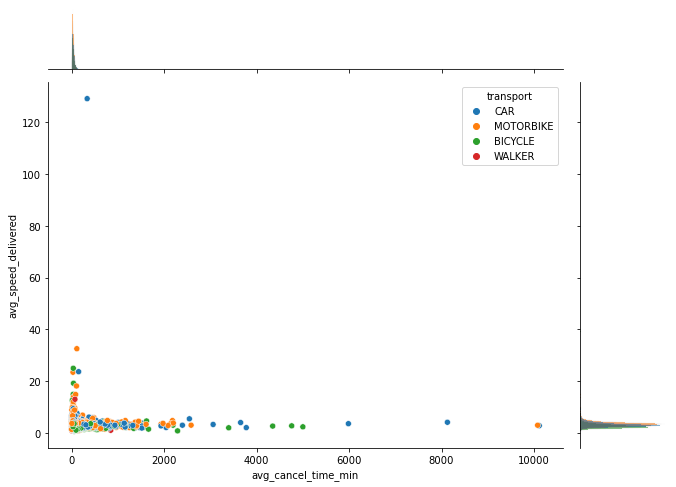

In [37]:
g = sns.JointGrid(data=courier, x="avg_cancel_time_min", y="avg_speed_delivered", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

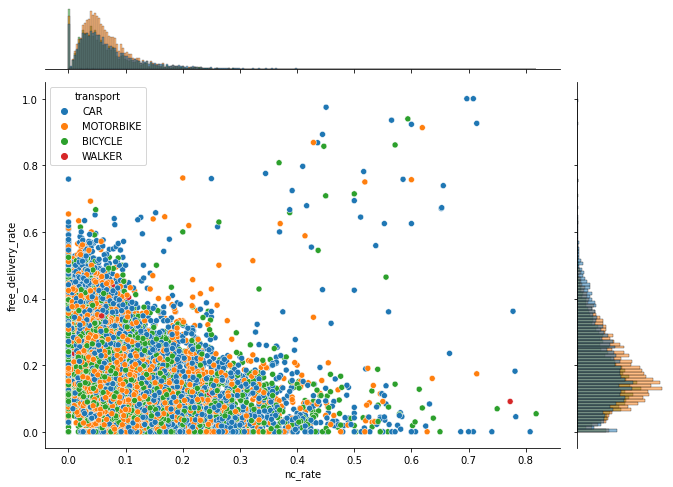

In [38]:
g = sns.JointGrid(data=courier, x="nc_rate", y="free_delivery_rate", hue="transport")
g.fig.set_size_inches(10,7)
g.plot(sns.scatterplot, sns.histplot)

# Anomaly detection - Multivariate analysis

In [39]:
transformed = courier_clean.copy()
courier_ids = transformed['courier_id']
transformed.index = transformed['courier_id']
transformed.drop(columns=['courier_id', 'transport', 'country_code'], inplace=True, axis=1)
transformed.fillna(-99, inplace=True)
X = StandardScaler().fit_transform(transformed)

## Z score

In [40]:
def find_outliers(feature):
    z = np.abs(stats.zscore(feature))
    idx_outliers = np.where(z>5,True,False)
    return pd.Series(idx_outliers, index=feature.index)

outliers = pd.DataFrame()
for col in transformed.columns:
    outliers[col] = find_outliers(transformed[col])

outliers['outlier'] = outliers.apply(lambda x: 1 if np.any(x) else 0, axis=1)
outliers[outliers.outlier==1]

# Worst-offenders
test =pd.DataFrame(outliers[outliers.outlier==1].sum(axis=1))
test[test[0]>4].sort_values(by=0, ascending=False)

/Users/patriciosanchez/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,0
courier_id,
46143410,10.0
42334006,8.0
64834593,8.0
57557871,8.0
52081250,8.0
...,...
49001238,5.0
31371415,5.0
64801291,5.0


In [41]:
# Top metrics triggered
test =pd.DataFrame(outliers[outliers.outlier==1].sum(axis=0))
test[test[0]>38]

,0
customers_per_order,243
cancel_rate,194
cash_cancel_rate,170
forgiven_rate,440
unpaid_rate,159
cash_unpaid_rate,233
avg_speed_delivered,39
avg_cancel_time_min,108
avg_notimmediate_cancel_time_min,106
fraudulent_rate,174


In [61]:
courier_id = 57063311
df = outliers[outliers.index==courier_id]
fired_metrics = df.columns[(df == 1).any(axis=0)].to_list()
display(fired_metrics)
display(courier[courier.courier_id==courier_id][fired_metrics[:-1]])
display(courier[courier.courier_id==courier_id])

['avg_cancel_time_min', 'avg_notimmediate_cancel_time_min', 'outlier']

,avg_cancel_time_min,avg_notimmediate_cancel_time_min
25546,5986.0,5986.0


,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
25546,57063311,CAR,RO,13,180,13.846154,178,0.988889,73,0.405556,...,0,1,0,0,17,13.692308,5.615385,44.884766,3.259787,4.438889


## Combination of z-scores

In [43]:
def find_zscore(feature):
    z = np.abs(stats.zscore(feature))
    return z

zscores = courier.copy()
for col in transformed.columns:
    zscores['z_score'+col] = find_zscore(transformed[col])
    
zscores['zscore_average'] = zscores.iloc[:,-45:].sum(axis=1)/45
test = zscores.copy()
test.index = zscores.courier_id

test2 = test.iloc[:,-46:][(test.iloc[:,-45:]<4)].copy()
test2[test2['zscore_average']>2]

/Users/patriciosanchez/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,z_scoreactive_days,z_scoreorders,z_scoreorder_per_day,z_scorecustomers_per_order,z_scorestores_per_order,z_scorecash_rate,z_scoredelivered_orders,z_scorecancel_rate,z_scorecash_cancel_rate,z_scoreforgiven_rate,...,z_scoreCAR,z_scoreMOTORBIKE,z_scoreWALKER,z_scorecountry_label,z_scorecustomers_daily,z_scorestores_daily,z_scorecourier_earned_gtv_daily,z_scorecourier_earned_gtv_per_delivered,z_scorecourier_reassignment_requests_per_order,zscore_average
courier_id,,,,,,,,,,,,,,,,,,,,,
57449785,NaN,1.053152,1.689756,NaN,1.261506,1.102726,1.167227,NaN,NaN,0.136206,...,0.675762,0.809225,0.074239,0.490130,1.867354,1.512375,1.032842,1.604820,3.115475,2.258017
55154724,NaN,1.237250,1.306522,0.655616,1.407869,0.594155,1.238981,0.773936,0.483175,0.135929,...,0.675762,0.809225,0.074239,0.745588,1.289039,0.557131,1.258634,0.978073,0.292997,2.069149
64834593,NaN,0.826570,1.381710,0.655616,1.103840,3.056243,1.023719,NaN,NaN,0.136483,...,0.675762,1.235751,0.074239,1.262454,1.366096,1.351848,1.402611,1.117045,0.268459,2.304011
66366877,NaN,1.279734,1.218257,0.655616,0.406962,2.470566,1.468595,NaN,NaN,0.136344,...,0.675762,0.809225,0.074239,1.054517,1.198580,0.780109,1.145488,1.578440,0.420495,2.892753
67278942,NaN,1.010668,0.940387,0.896533,0.942647,3.027277,1.081122,NaN,2.883386,0.136390,...,0.675762,1.235751,0.074239,1.262454,0.980810,1.094566,1.331039,1.344594,0.259847,2.071909
56364373,NaN,1.265573,1.528818,0.655616,1.201533,0.934112,1.310736,NaN,NaN,0.136483,...,1.479811,0.809225,0.074239,0.490130,1.516860,1.437609,0.420014,3.319079,0.360223,2.418543
62890758,NaN,0.883215,0.955666,NaN,1.218757,2.084966,0.865860,0.740396,0.483175,0.136483,...,0.675762,1.235751,0.074239,0.799059,0.493328,2.050000,0.612607,1.194163,0.289354,2.658001
66930816,NaN,1.208927,0.973078,0.655616,0.695064,2.055304,1.353788,NaN,NaN,0.136344,...,0.675762,0.809225,0.074239,1.054517,0.947307,0.437066,0.888478,0.579096,0.425726,2.714666
65518703,NaN,1.109798,1.600737,NaN,0.297488,3.145367,1.267683,NaN,NaN,0.136483,...,0.675762,1.235751,0.074239,1.262454,1.711178,1.277522,1.489177,1.212350,3.115475,2.251670


## Isolation Forest

In [44]:
df_output = courier.copy()
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), random_state=21)
model.fit(X)
df_output['anomaly_score'] = model.predict(X)
df_output[df_output['anomaly_score']==-1]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order,anomaly_score
54,65119966,CAR,BG,11,165,15.000000,147,0.890909,21,0.127273,...,1,0,0,1,13.363636,1.909091,27.378246,1.955589,NaN,-1
127,61551834,CAR,PL,4,36,9.000000,33,0.916667,1,0.027778,...,1,0,0,15,8.250000,0.250000,15.915376,1.768375,NaN,-1
155,61670686,MOTORBIKE,IT,14,208,14.857143,170,0.817308,11,0.052885,...,0,1,0,7,12.142857,0.785714,115.307857,7.836456,0.177885,-1
156,58484760,BICYCLE,UA,5,23,4.600000,22,0.956522,10,0.434783,...,0,0,0,20,4.400000,2.000000,8.504951,1.848902,0.043478,-1
191,64901315,CAR,BG,10,67,6.700000,66,0.985075,19,0.283582,...,1,0,0,1,6.600000,1.900000,12.106113,2.051883,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38043,67236180,MOTORBIKE,SI,4,27,6.750000,27,1.000000,15,0.555556,...,0,1,0,19,6.750000,3.750000,40.387500,5.983333,NaN,-1
38140,61617958,MOTORBIKE,NG,7,22,3.142857,19,0.863636,16,0.727273,...,0,1,0,14,2.714286,2.285714,4.370187,1.911957,0.909091,-1
38223,67068146,BICYCLE,SI,6,46,7.666667,46,1.000000,29,0.630435,...,0,0,0,19,7.666667,4.833333,48.888333,6.376739,NaN,-1
38261,66326107,BICYCLE,RO,3,45,15.000000,42,0.933333,11,0.244444,...,0,0,0,17,14.000000,3.666667,30.779157,2.885546,5.222222,-1


In [45]:
df_output[(df_output['anomaly_score']==-1) & (df_output['country_code']=='ES')]

,courier_id,transport,country_code,active_days,orders,order_per_day,customers,customers_per_order,stores,stores_per_order,...,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order,anomaly_score
4075,333465,BICYCLE,ES,11,329,29.909091,318,0.966565,184,0.559271,...,0,0,0,3,28.909091,16.727273,105.567273,3.529605,18.790274,-1
5002,55515312,CAR,ES,5,29,5.800000,26,0.896552,9,0.310345,...,1,0,0,3,5.200000,1.800000,35.940000,6.196552,NaN,-1
7408,55866095,CAR,ES,4,30,7.500000,29,0.966667,15,0.500000,...,1,0,0,3,7.250000,3.750000,32.737500,4.676786,0.233333,-1
8824,58255150,CAR,ES,12,34,2.833333,31,0.911765,4,0.117647,...,1,0,0,3,2.583333,0.333333,21.155833,8.189355,NaN,-1
9715,46143410,CAR,ES,8,117,14.625000,32,0.273504,10,0.085470,...,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103,-1
12765,66938733,MOTORBIKE,ES,5,37,7.400000,32,0.864865,11,0.297297,...,0,1,0,3,6.400000,2.200000,91.822000,12.753056,1.000000,-1
16279,9128772,MOTORBIKE,ES,1,21,21.000000,21,1.000000,16,0.761905,...,0,1,0,3,21.000000,16.000000,77.520000,3.691429,2.190476,-1
16728,58338066,BICYCLE,ES,11,24,2.181818,23,0.958333,4,0.166667,...,0,0,0,3,2.090909,0.363636,18.874545,9.026957,NaN,-1
19704,29973056,CAR,ES,14,363,25.928571,351,0.966942,186,0.512397,...,1,0,0,3,25.071429,13.285714,123.777857,4.813583,7.300275,-1
29840,66334051,MOTORBIKE,ES,4,25,6.250000,22,0.880000,11,0.440000,...,0,1,0,3,5.500000,2.750000,38.030000,6.613913,0.480000,-1


In [46]:
df_output[df_output.courier_id==58051573][['gtv_avg',
 'avg_courier_earned_minus_gtv',
 'avg_courier_earned_minus_purchases_gtv']]

,gtv_avg,avg_courier_earned_minus_gtv,avg_courier_earned_minus_purchases_gtv
7969,14.864286,-9.686429,-12.372143


## Clustering

In [47]:
# Choose K
#cost = []
#for num_clusters in list(range(1,20)):
#    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
#    kmode.fit_predict(transformed)
#    cost.append(kmode.cost_)
    
#y = np.array([i for i in range(1,20,1)])
#plt.plot(y,cost)    

In [48]:
km_cao = KModes(n_clusters=3, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(transformed)

fitClusters_cao

data_combined = transformed.copy().reset_index()
clusters = pd.DataFrame(fitClusters_cao)
clusters.columns = ['cluster_predicted']
data_combined = pd.concat([data_combined, clusters], axis = 1).reset_index()
#data_combined = data_combined.drop(['index', 'level_0'], axis = 1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9608, cost: 1205442.0
Run 1, iteration: 2/100, moves: 2791, cost: 1205186.0
Run 1, iteration: 3/100, moves: 84, cost: 1205186.0


In [49]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = transformed.columns
clusterCentroidsDf

,active_days,orders,order_per_day,customers_per_order,stores_per_order,cash_rate,delivered_orders,cancel_rate,cash_cancel_rate,forgiven_rate,...,BICYCLE,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order
0,12.0,23.0,11.0,1.0,0.5,0.0,22.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,3.0,9.0,4.0,25.896667,4.8300,-99.0
1,14.0,26.0,11.0,1.0,0.5,0.0,25.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,17.0,11.0,4.0,24.852000,4.4675,-99.0
2,12.0,21.0,7.0,1.0,0.5,0.0,21.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,20.0,7.0,3.0,17.360000,3.5470,-99.0


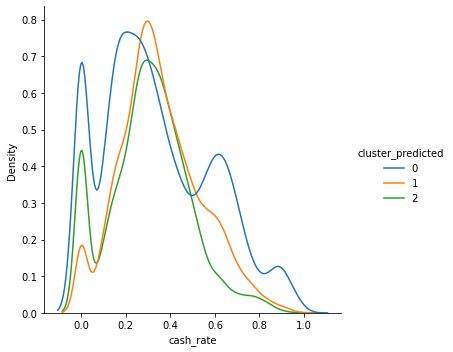

In [50]:
sns.displot(x=data_combined['cash_rate'], hue=data_combined['cluster_predicted'], kind='kde', palette='tab10')

(-0.025, 0.1)

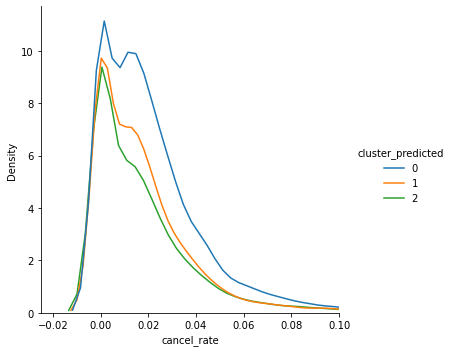

In [51]:
sns.displot(x=data_combined['cancel_rate'], hue=data_combined['cluster_predicted'], kind='kde', palette='tab10')
plt.xlim(-0.025, 0.1)

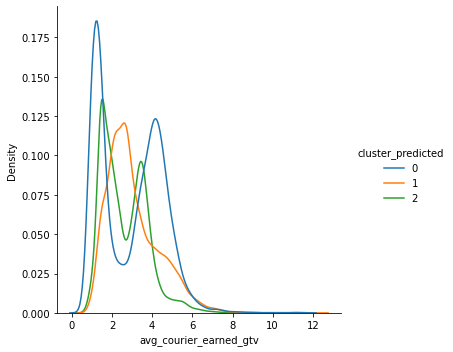

In [52]:
sns.displot(x=data_combined['avg_courier_earned_gtv'], hue=data_combined['cluster_predicted'], kind='kde', palette='tab10')

## PCA

In [53]:
def pca_decomp(data_input, n_components):
    pca = PCA(n_components)
    principal_components = pca.fit_transform(data_input)
    cols = list(range(0,n_components))
    df_output = pd.DataFrame(data = principal_components, columns = cols)
    return df_output

def plot_pca(df_input, x_axis, y_axis):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(x_axis), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(y_axis), fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, -1]
    colors = ['orange', 'green']
    for target, color in zip(targets,colors):
        indicesToKeep = pca_isolation['anomaly_score'] == target
        ax.scatter(pca_isolation.loc[indicesToKeep, x_axis], pca_isolation.loc[indicesToKeep, y_axis], c = color, s = 10)
    ax.legend(targets)
    ax.grid()

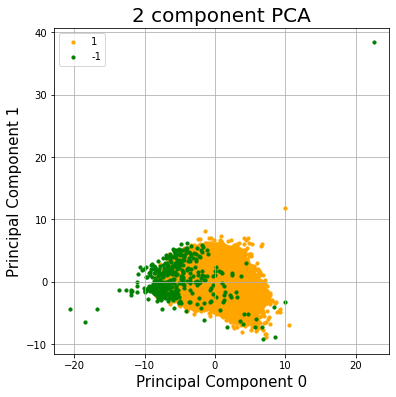

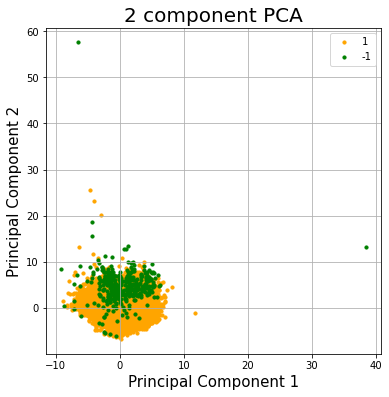

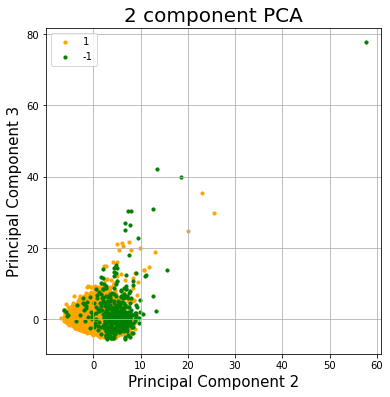

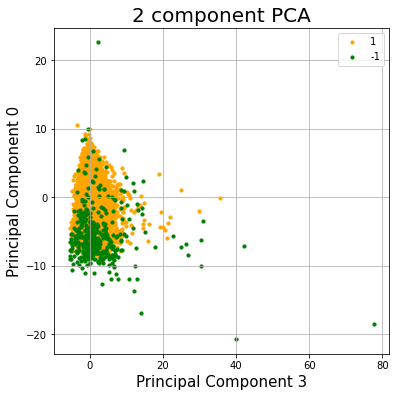

In [54]:
pca_df = pca_decomp(X, 4)
pca_isolation = pd.merge(pca_df, df_output, how='inner', left_index=True, right_index=True)
plot_pca(pca_isolation, 0, 1)
plot_pca(pca_isolation, 1, 2)
plot_pca(pca_isolation, 2, 3)
plot_pca(pca_isolation, 3, 0)

In [55]:
pca_isolation[pca_isolation[2] > 20]

,0,1,2,3,courier_id,transport,country_code,active_days,orders,order_per_day,...,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order,anomaly_score
9715,-18.431050,-6.464289,57.575511,77.681077,46143410,CAR,ES,8,117,14.625000,...,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103,-1
22345,-1.971223,-4.648265,25.523153,29.893534,66348153,CAR,ES,11,96,8.727273,...,1,0,0,3,8.272727,1.454545,42.733636,4.948105,NaN,1
29439,1.054926,-2.887532,20.117131,24.796900,67236890,CAR,ES,5,59,11.800000,...,1,0,0,3,11.800000,3.400000,67.176000,5.791034,0.254237,1
34441,-0.043886,-4.018361,23.102268,35.460144,53441709,MOTORBIKE,ES,10,48,4.800000,...,0,1,0,3,4.800000,3.200000,19.637000,4.178085,4.708333,1


In [56]:
pca_isolation[pca_isolation[0] < -10]

,0,1,2,3,courier_id,transport,country_code,active_days,orders,order_per_day,...,CAR,MOTORBIKE,WALKER,country_label,customers_daily,stores_daily,courier_earned_gtv_daily,courier_earned_gtv_per_delivered,courier_reassignment_requests_per_order,anomaly_score
191,-11.102168,-0.649254,6.840483,1.255308,64901315,CAR,BG,10,67,6.700000,...,1,0,0,1,6.600000,1.900000,12.106113,2.051883,NaN,-1
201,-10.905646,1.215941,9.892231,5.253632,57449785,BICYCLE,IT,13,37,2.846154,...,0,0,0,7,1.923077,0.615385,12.295385,5.708571,NaN,-1
3328,-11.851401,-1.440570,9.112129,12.882675,64834593,MOTORBIKE,CI,12,53,4.416667,...,0,1,0,2,4.416667,1.083333,4.488861,1.417535,0.528302,-1
3470,-10.046432,1.992808,7.959156,30.411898,66366877,BICYCLE,RO,4,21,5.250000,...,0,0,0,17,5.250000,2.750000,9.917222,5.666984,5.000000,-1
3828,-11.935835,-2.153068,7.747875,7.823968,67278942,MOTORBIKE,CI,6,40,6.666667,...,0,1,0,2,6.333333,1.833333,5.999885,1.058803,0.275000,-1
5688,-16.839862,-4.347288,15.619086,13.889757,52081250,CAR,PL,12,40,3.333333,...,1,0,0,15,3.333333,1.083333,25.181990,7.554597,3.475000,-1
7304,-11.059452,0.021371,5.764377,-1.409312,63854516,CAR,BG,5,36,7.200000,...,1,0,0,1,7.200000,2.000000,13.836404,1.976629,NaN,-1
9715,-18.431050,-6.464289,57.575511,77.681077,46143410,CAR,ES,8,117,14.625000,...,1,0,0,3,4.000000,1.250000,73.658750,6.475495,12.564103,-1
13535,-10.119318,-0.965718,7.171431,6.523704,59053199,MOTORBIKE,CI,13,63,4.846154,...,0,1,0,2,3.923077,1.153846,5.243074,1.363199,0.492063,-1
14851,-10.336803,1.839348,8.375302,-2.084527,67308085,CAR,HR,2,26,13.000000,...,1,0,0,6,13.000000,2.000000,41.279046,3.302324,NaN,-1


## Local Outlier Factor

In [57]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X)

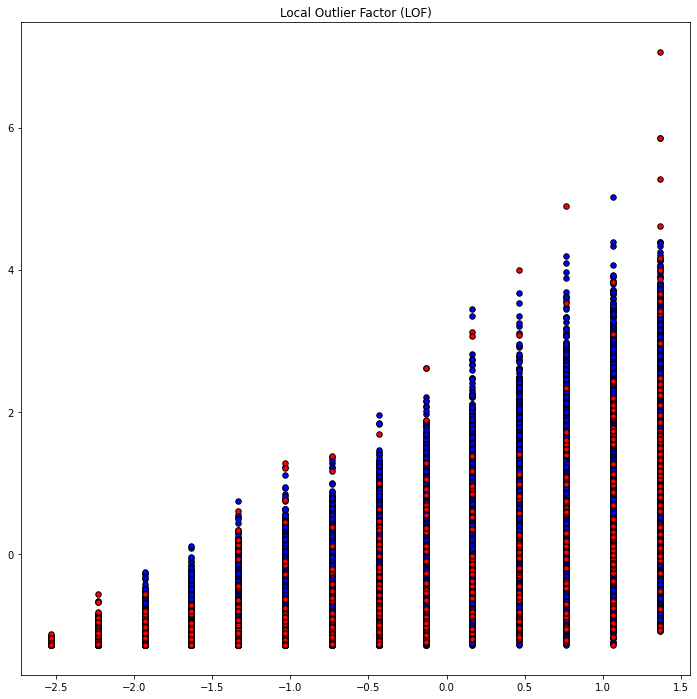

In [58]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
#plt.xlabel('Age');
#plt.ylabel('Cholestrol');
plt.show()

NameError: name 'radius' is not defined

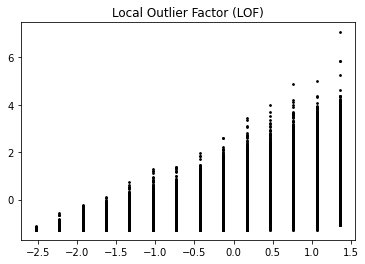

In [59]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
#n_errors = (y_pred != ground_truth).sum()
#X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
#radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [ ]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
#radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 1], X[:, 2], edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-3, 2))
plt.ylim((-2, 10))
plt.xlabel("prediction errors: %d")
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

# Impact Estimation

In [ ]:
# IA document: https://docs.google.com/spreadsheets/d/1y5oqcpreqffDAIPc-dTubvKgptmo0I7pam1Wl3S3hHI/edit?usp=sharing

